In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [58]:
# need this cell to import the help functions:

import os
path_sections = os.getcwd().split('\\')
if path_sections[-1] != 'CGM':
    os.chdir('./..')

In [59]:
# import help functions:

from data_processing.cgm_data import CGMData
from data_processing.cgm_data_helper import plot_series_with_food
from data_processing.derived_datasets import max_glucose_dataset,max_glucose_between_meals_dataset

from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

In [60]:
data = CGMData()

In [61]:
# Finding 5/95th percentile idea from Dan Visscher

high_glu = []
low_glu = []

# Find 5th/95th percentile for glucose range for each patient
for i in range(1,3):
    low_glu.append(np.percentile(data[i].glu, 5))
    high_glu.append(np.percentile(data[i].glu, 95))




In [62]:
print(high_glu)
print(low_glu)

[137.0, 167.0]
[85.0, 99.0]


In [63]:
# participant_numbers = data.shape()
participant_numbers = 2

In [64]:
for pn in range(1,participant_numbers):
    # Select participant number
    participant_number = pn
    high_glu_par = high_glu[participant_number-1]

    # Max glucose between meals:
    df = max_glucose_dataset(cgm_data=data,participant_num=participant_number,glu_thresh=high_glu_par)
    df = pd.concat([df, pd.DataFrame(df)])

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, 0 to 19
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   calorie        40 non-null     float64
 1   total_carb     40 non-null     float64
 2   dietary_fiber  6 non-null      float64
 3   sugar          40 non-null     float64
 4   protein        40 non-null     float64
 5   total_fat      6 non-null      float64
 6   recent_meals   40 non-null     float64
 7   participant    40 non-null     int64  
 8   max_glucose    40 non-null     int64  
 9   high_glucose   40 non-null     bool   
dtypes: bool(1), float64(7), int64(2)
memory usage: 3.2 KB


In [81]:
X = df.total_carb.values
y = df.high_glucose.values

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                       shuffle=True,
                                                       random_state=435,
                                                       test_size=.2,
                                                       stratify=y)

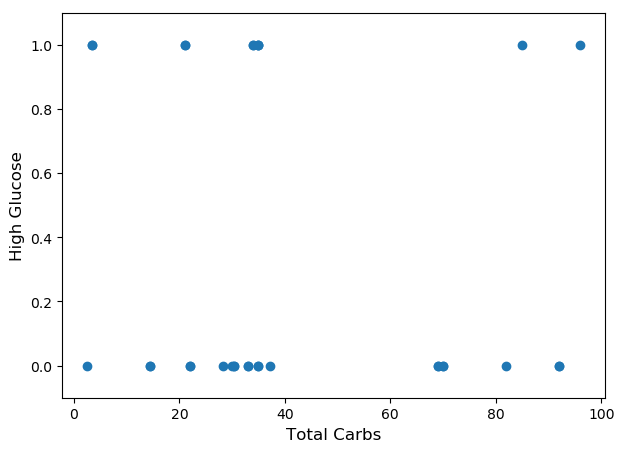

In [83]:
plt.figure(figsize = (7,5))

plt.scatter(X_train,y_train)
plt.ylim((-.1,1.1))
plt.xlabel("Total Carbs",fontsize = 12)
plt.ylabel("High Glucose",fontsize = 12)

plt.show()

In [84]:
## make model object
## Remember to include penalty=None when calling LogisticRegression
log_reg = LogisticRegression(penalty=None)

## fit the model
log_reg.fit(X_train.reshape(-1,1),
            y_train)

LogisticRegression(penalty=None)

In [85]:
log_reg.predict(X_train.reshape(-1,1))

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [86]:
## Demonstrate predict_proba
log_reg.predict_proba(X_train.reshape(-1,1))

array([[0.64541614, 0.35458386],
       [0.57024889, 0.42975111],
       [0.76011547, 0.23988453],
       [0.718968  , 0.281032  ],
       [0.76011547, 0.23988453],
       [0.74748302, 0.25251698],
       [0.57239264, 0.42760736],
       [0.61367614, 0.38632386],
       [0.64318725, 0.35681275],
       [0.59835172, 0.40164828],
       [0.61367614, 0.38632386],
       [0.718968  , 0.281032  ],
       [0.64541614, 0.35458386],
       [0.64541614, 0.35458386],
       [0.64541614, 0.35458386],
       [0.63511235, 0.36488765],
       [0.63013966, 0.36986034],
       [0.76713703, 0.23286297],
       [0.64318725, 0.35681275],
       [0.64095215, 0.35904785],
       [0.59835172, 0.40164828],
       [0.63421033, 0.36578967],
       [0.63511235, 0.36488765],
       [0.74193615, 0.25806385],
       [0.64095215, 0.35904785],
       [0.61597931, 0.38402069],
       [0.64541614, 0.35458386],
       [0.57239264, 0.42760736],
       [0.71699872, 0.28300128],
       [0.61597931, 0.38402069],
       [0.

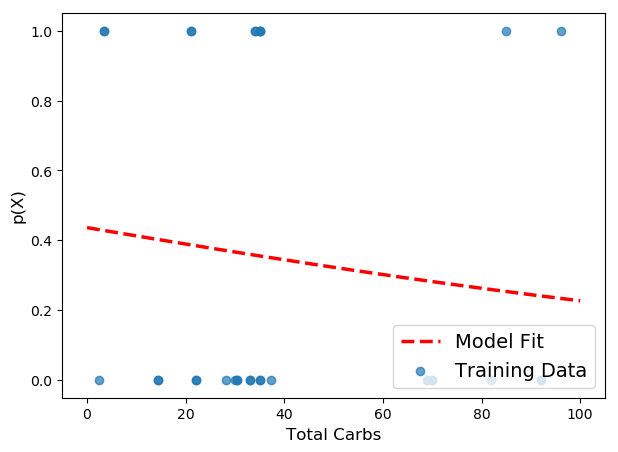

In [88]:
# Plot figure 
plt.figure(figsize = (7,5))

# With classifications we have a new method
# predict_proba which returns the probability
# that an observation is a certain class.
plt.plot(np.linspace(0,100,1000),
            log_reg.predict_proba(np.linspace(0,100,1000).reshape(-1,1))[:,1],
            'r--',linewidth=2.5,label = "Model Fit")
plt.scatter(X_train,y_train,label = 'Training Data',alpha=.7)
plt.legend(fontsize = 14,loc = 4)
plt.xlabel("Total Carbs",fontsize = 12)
plt.ylabel("p(X)",fontsize=12) 

plt.show()

In [91]:
## set the cutoff
cutoff = .5

## store the predicted probabilities
y_prob = log_reg.predict_proba(X_train.reshape(-1,1))[:,1]

## assign the value based on the cutoff
y_train_pred = 1*(y_prob >= cutoff)

## print the accuracy
## input the accuracy after "is",
print("The training accuracy for a cutoff of",cutoff,
      "is", np.sum(y_train_pred == y_train)/len(y_train))

The training accuracy for a cutoff of 0.5 is 0.65625


In [92]:
## Now plot how the accuracy changes with the cutoff
cutoffs = np.arange(0,1.01,.01)
accs = []

for cutoff in cutoffs:
    y_train_pred = 1*(y_prob >= cutoff)
    accs.append(np.sum(y_train_pred == y_train)/len(y_train))

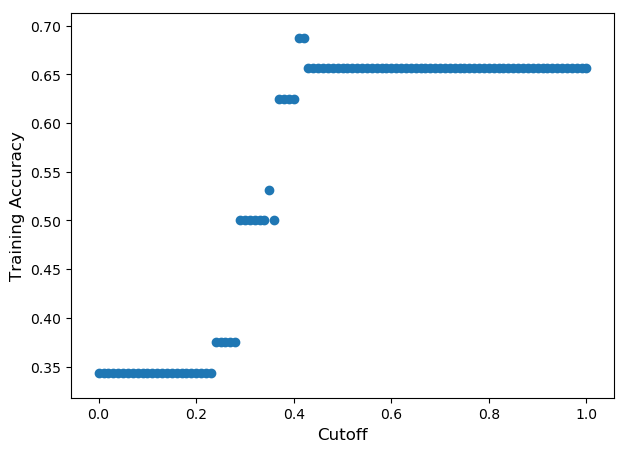

In [93]:
plt.figure(figsize=(7,5))

plt.scatter(cutoffs,accs)

plt.xlabel("Cutoff",fontsize=12)
plt.ylabel("Training Accuracy",fontsize=12)

plt.show()

In [96]:
## demonstrate log_reg.coef_
log_reg.coef_[0][0]

-0.009725653380039565

In [97]:
print("A .1 unit increase in our feature multiplies" + 
      " the odds of being classified as 1 by " + 
      str(np.round(np.exp(.1*log_reg.coef_[0][0]),2)))

A .1 unit increase in our feature multiplies the odds of being classified as 1 by 1.0


next steps: 
1. put in data from all but the hold out participants
2. use first predictor project code to get baseline model predictions